#Severe Weather Forecasting with Python and Data Science Tools: Interactive Demo
David John Gagne


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from mpl_toolkits.basemap import Basemap
from IPython.display import display
from IPython.html import widgets
from scipy.ndimage import gaussian_filter, find_objects

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [64]:
from hagelslag.processing.EnhancedWatershedSegmenter import EnhancedWatershed
from hagelslag.data.ModelOutput import ModelOutput
from hagelslag.processing.ObjectMatcher import ObjectMatcher, shifted_centroid_distance, closest_distance
from hagelslag.processing.STObject import STObject

In [3]:
ensemble_name = "SSEF"
member ="wrf-s3cn_arw"
run_date = datetime(2015, 6, 4)
variable = "uh_max"
start_date = run_date + timedelta(hours=12)
end_date = run_date + timedelta(hours=29)
model_path = "/Users/djgagne/research/spring2015_unidata/"
model_grid = ModelOutput(ensemble_name, 
                         member, 
                         run_date, 
                         variable, 
                         start_date, 
                         end_date,
                         model_path,
                         single_step=False)
model_grid.load_data()
model_grid.load_map_info("../mapfiles/ssef2015.map")

Loading SSEF


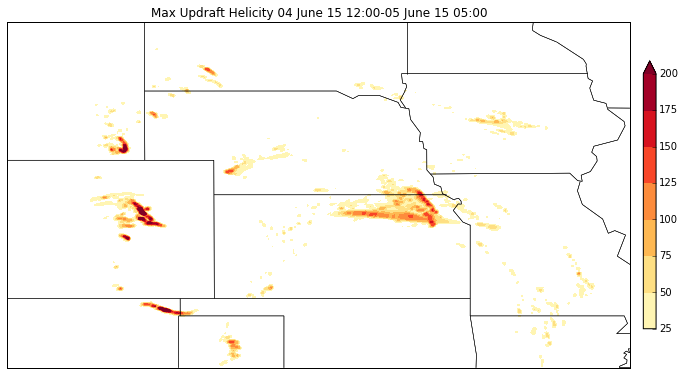

In [4]:
lon_range = (-108, -90)
lat_range = (35, 45)
basemap = Basemap(projection="cyl", 
                  resolution="l",
                  llcrnrlon=lon_range[0], 
                  urcrnrlon=lon_range[1],
                  llcrnrlat=lat_range[0],
                  urcrnrlat=lat_range[1])
plt.figure(figsize=(12,8))
basemap.drawstates()
plt.contourf(model_grid.lon, 
             model_grid.lat, 
             model_grid.data.max(axis=0), 
             np.arange(25,225,25), 
             extend="max",
             cmap="YlOrRd")
plt.colorbar(shrink=0.6, fraction=0.05, pad=0.02 )
plt.title("Max Updraft Helicity {0}-{1}".format(start_date.strftime("%d %B %y %H:%M"), 
                                                end_date.strftime("%d %B %y %H:%M")))

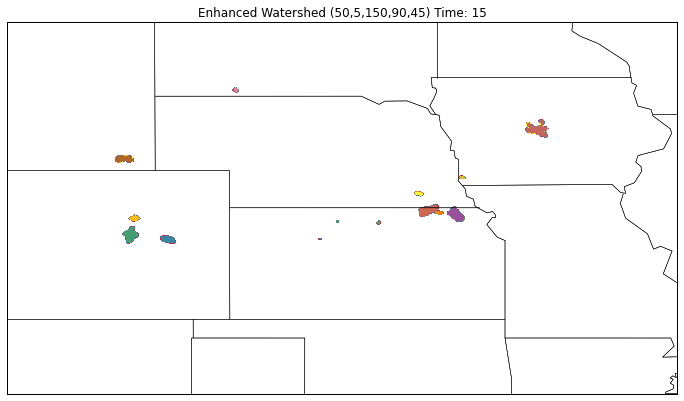

In [106]:
def ew_demo(min_val=5, step_val=1, max_val=100, size_val=50, delta_val=5, time=12):
    ew = EnhancedWatershed(25,5,200,size_val,50)
    plt.figure(figsize=(12,8))
    basemap.drawstates()
    labels = ew.label(gaussian_filter(model_grid.data[time], 1))
    plt.contourf(model_grid.lon, 
                 model_grid.lat, 
                 labels, 
                 np.arange(1,labels.max()), 
                 extend="max",
                 cmap="Set1")
    plt.xlim(*lon_range)
    plt.ylim(*lat_range)
    plt.grid()
    plt.title("Enhanced Watershed ({0:d},{1:d},{2:d},{3:d},{4:d}) Time: {5:d}".format(min_val, 
                                                                                      step_val, 
                                                                                      max_val, 
                                                                                      size_val, 
                                                                                      delta_val, 
                                                                                      time))
min_slider = widgets.IntSlider(min=10, max=300, step=10, value=25)
step_slider = widgets.IntSlider(min=1, max=10, step=1, value=5)
max_slider = widgets.IntSlider(min=100, max=300, step=10, value=150)
size_slider = widgets.IntSlider(min=5, max=200, step=5)
delta_slider = widgets.IntSlider(min=5, max=100, step=5)
time_slider = widgets.IntSlider(min=0, max=model_grid.data.shape[0]-1, value=12)
w = widgets.interactive(ew_demo, 
                        min_val=min_slider,          
                        step_val=step_slider, 
                        max_val=max_slider, 
                        size_val=size_slider, 
                        delta_val=delta_slider,
                        time=time_slider)
display(w)

In [96]:
def get_forecast_objects(model_grid, ew_params, min_size, gaussian_window):
    ew = EnhancedWatershed(*ew_params)
    model_objects = []
    for h, hour in enumerate(np.arange(model_grid.start_hour, model_grid.end_hour + 1)):
        print "Find model objects Hour: {0:02d}".format(hour)
        hour_labels = ew.size_filter(ew.label(gaussian_filter(model_grid.data[h], gaussian_window)), min_size)
        obj_slices = find_objects(hour_labels)
        num_slices = len(obj_slices)
        model_objects.append([])
        if num_slices > 0:
            for sl in obj_slices:   
                model_objects[-1].append(STObject(model_grid.data[h][sl],
                                                  np.where(hour_labels[sl] > 0, 1, 0),
                                                  model_grid.x[sl], 
                                                  model_grid.y[sl], 
                                                  model_grid.i[sl], 
                                                  model_grid.j[sl],
                                                  hour,
                                                  hour,
                                                  dx=3000))
                if h > 0:
                    model_objects[-1][-1].estimate_motion(hour, model_grid.data[h-1], 25, 25)
    return model_objects

def track_forecast_objects(model_objects, model_grid, object_matcher):
    hours = np.arange(int(model_grid.start_hour), int(model_grid.end_hour) + 1)
    tracked_model_objects = []
    for h, hour in enumerate(hours):
        past_time_objs = []
        for obj in tracked_model_objects:
            # Potential trackable objects are identified
            if obj.end_time == hour - 1:
                past_time_objs.append(obj)
        # If no objects existed in the last time step, then consider objects in current time step all new
        if len(past_time_objs) == 0:
            tracked_model_objects.extend(model_objects[h])
        # Match from previous time step with current time step
        elif len(past_time_objs) > 0 and len(model_objects[h]) > 0:
            assignments = object_matcher.match_objects(past_time_objs, model_objects[h], hour - 1, hour)
            unpaired = range(len(model_objects[h]))
            for pair in assignments:
                past_time_objs[pair[0]].extend(model_objects[h][pair[1]])
                unpaired.remove(pair[1])
            if len(unpaired) > 0:
                for up in unpaired:
                    tracked_model_objects.append(model_objects[h][up])
        print("Tracked Model Objects: {0:03d} Hour: {1:02d}".format(len(tracked_model_objects), hour))
    return tracked_model_objects   

In [107]:
model_objects = get_forecast_objects(model_grid, (25, 5, 200, 90, 50), 20, 2)
object_matcher = ObjectMatcher([shifted_centroid_distance], 
                               np.array([1]), np.array([24000]))
tracked_model_objects = track_forecast_objects(model_objects, model_grid, object_matcher)

Find model objects Hour: 12
Find model objects Hour: 13
Find model objects Hour: 14
Find model objects Hour: 15
Find model objects Hour: 16
Find model objects Hour: 17
Find model objects Hour: 18
Find model objects Hour: 19
Find model objects Hour: 20
Find model objects Hour: 21
Find model objects Hour: 22
Find model objects Hour: 23
Find model objects Hour: 24
Find model objects Hour: 25
Find model objects Hour: 26
Find model objects Hour: 27
Find model objects Hour: 28
Find model objects Hour: 29
Tracked Model Objects: 003 Hour: 12
Tracked Model Objects: 003 Hour: 13
Tracked Model Objects: 005 Hour: 14
Tracked Model Objects: 006 Hour: 15
Tracked Model Objects: 008 Hour: 16
Tracked Model Objects: 008 Hour: 17
Tracked Model Objects: 010 Hour: 18
Tracked Model Objects: 010 Hour: 19
Tracked Model Objects: 012 Hour: 20
Tracked Model Objects: 014 Hour: 21
Tracked Model Objects: 016 Hour: 22
Tracked Model Objects: 022 Hour: 23
Tracked Model Objects: 025 Hour: 24
Tracked Model Objects: 027 H

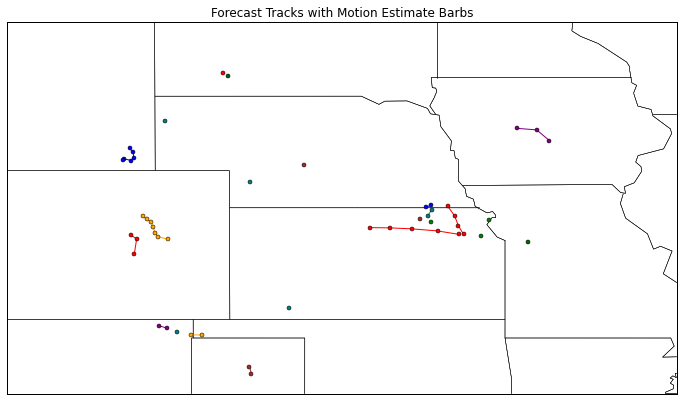

In [125]:
color_list = np.random.choice(["red", "orange", "blue", "green", "purple", "darkgreen", "teal", "brown"], size=len(tracked_model_objects))
plt.figure(figsize=(12, 8))
basemap.drawstates()
for t, tracked_model_object in enumerate(tracked_model_objects):
    traj = tracked_model_object.trajectory()
    t_lon, t_lat = model_grid.proj(traj[0], traj[1], inverse=True)
    plt.plot(t_lon, t_lat, marker='o', markersize=4, color=color_list[t])
    #plt.barbs(t_lon, t_lat, tracked_model_object.u /3000, 
    #          tracked_model_object.v / 3000.0, length=6,
    #          barbcolor=color_list[t])
plt.title("Forecast Tracks with Motion Estimate Barbs")